In [1]:
import psycopg2
import pandas as pds
from sqlalchemy import create_engine
import settings as conf
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
pds.options.mode.chained_assignment = None

## Establish Connection

In [2]:
DB_USER = conf.db_user
DB_PASS = conf.db_pass
DB_HOST = conf.db_host
DB_PORT = 5432
DB = conf.database


alchemyEngine   = create_engine('postgresql+psycopg2://' + DB_USER + ':' + DB_PASS
                                + '@' + DB_HOST + ':' + str(DB_PORT) + '/' + DB, pool_recycle=3600);
dbConnection    = alchemyEngine.connect();

## Fetch Full required dataframe for recommendations

In [3]:
full_rating_df       = pds.read_sql("select a.student_id, a.teacher_id, b.name as skill, \
                                        c.state_name as student_state, c.city_name as student_city, \
                                        c.LATITUDE as student_lat, c.LONGITUDE as student_lon,\
                                        d.state_name as teacher_state, d.city_name as teacher_city, \
                                        d.LATITUDE as teacher_lat, d.LONGITUDE as teacher_lon, b.tags, \
                                        a.skill_rating, a.language_rating, a.communication_rating, a.punctuality_rating \
                                from Teacher_rating a \
                                    inner join skills b \
                                        on a.skill_id = b.row_id \
                                    inner join user_account e \
                                        on a.student_id = e.user_id \
                                    inner join user_account f \
                                        on a.teacher_id = f.user_id \
                                    inner join user_location c \
                                        on c.row_id = e.location_id \
                                    inner join user_location d \
                                        on d.row_id = f.location_id;"
                               , dbConnection);
full_rating_df.head(3)

,student_id,teacher_id,skill,student_state,student_city,student_lat,student_lon,teacher_state,teacher_city,teacher_lat,teacher_lon,tags,skill_rating,language_rating,communication_rating,punctuality_rating
0,1489,3075,French,Tamilnadu,Coimbatore,11.0100,76.9069,Tamilnadu,Chennai,13.0683,80.2317,"languages, writing",1,4,3,1
1,1441,3500,Health,Uttar Pradesh,Prayagraj,25.4620,81.8949,Uttar Pradesh,Lucknow,26.8397,80.9578,"medical, firstAid, paramedic, nutrition, workout",5,4,5,1
2,1922,3708,Instrumental Music,Tamilnadu,Chennai,13.0398,80.2507,Tamilnadu,Chennai,13.1035,80.2251,"music, arts, artist",4,2,4,1


In [4]:
rating_df = full_rating_df[['teacher_id', 'skill', 'skill_rating', 'language_rating', 'communication_rating', 'punctuality_rating']]
rating_df.describe()['skill_rating'].T

count    9964.000000
mean        3.365817
std         1.354158
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: skill_rating, dtype: float64

In [5]:
print('Minimum rating is: %d' %(rating_df.skill_rating.min()))
print('Maximum rating is: %d' %(rating_df.skill_rating.max()))

Minimum rating is: 1
Maximum rating is: 5


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


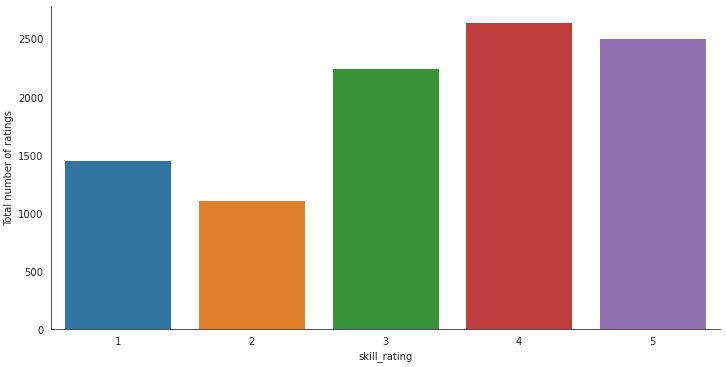

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style('white'):
    g = sns.catplot("skill_rating", data=rating_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [7]:
num_rating_df = rating_df.groupby(["teacher_id", "skill"]).count()['skill_rating'].reset_index()
num_rating_df.rename(columns={'skill_rating':'num_ratings'},inplace=True)
num_rating_df.head()


,teacher_id,skill,num_ratings
0,3004,Speech,8
1,3005,Handwriting,9
2,3006,Handwriting,9
3,3007,Modern Literature,16
4,3008,Language Arts,9


In [8]:
avg_skill_rating = rating_df.groupby(["teacher_id", "skill"]).mean()['skill_rating'].reset_index()
avg_skill_rating.rename(columns={'skill_rating':'avg_skill_rating'},inplace=True)
avg_skill_rating

,teacher_id,skill,avg_skill_rating
0,3004,Speech,3.375000
1,3005,Handwriting,2.555556
2,3006,Handwriting,3.444444
3,3007,Modern Literature,3.687500
4,3008,Language Arts,2.888889
...,...,...,...
994,3998,Earth Science,3.909091
995,3999,Ecology,3.750000
996,4000,Art,3.500000
997,4001,Dramatics,3.769231


In [9]:
avg_lang_rating = rating_df.groupby(["teacher_id", "skill"]).mean()['language_rating'].reset_index()
avg_lang_rating.rename(columns={'language_rating':'avg_lang_rating'},inplace=True)
avg_lang_rating

,teacher_id,skill,avg_lang_rating
0,3004,Speech,3.375000
1,3005,Handwriting,3.111111
2,3006,Handwriting,3.111111
3,3007,Modern Literature,3.625000
4,3008,Language Arts,3.111111
...,...,...,...
994,3998,Earth Science,4.000000
995,3999,Ecology,2.666667
996,4000,Art,2.125000
997,4001,Dramatics,2.923077


In [10]:
avg_comm_rating = rating_df.groupby(["teacher_id", "skill"]).mean()['communication_rating'].reset_index()
avg_comm_rating.rename(columns={'communication_rating':'avg_comm_rating'},inplace=True)
avg_comm_rating

,teacher_id,skill,avg_comm_rating
0,3004,Speech,3.625000
1,3005,Handwriting,3.222222
2,3006,Handwriting,3.333333
3,3007,Modern Literature,3.375000
4,3008,Language Arts,3.333333
...,...,...,...
994,3998,Earth Science,3.454545
995,3999,Ecology,3.250000
996,4000,Art,3.750000
997,4001,Dramatics,3.461538


In [11]:
avg_punc_rating = rating_df.groupby(["teacher_id", "skill"]).mean()['punctuality_rating'].reset_index()
avg_punc_rating.rename(columns={'punctuality_rating':'avg_punc_rating'},inplace=True)
avg_punc_rating

,teacher_id,skill,avg_punc_rating
0,3004,Speech,3.625000
1,3005,Handwriting,3.111111
2,3006,Handwriting,3.111111
3,3007,Modern Literature,3.687500
4,3008,Language Arts,3.444444
...,...,...,...
994,3998,Earth Science,3.363636
995,3999,Ecology,3.166667
996,4000,Art,4.000000
997,4001,Dramatics,3.230769


In [12]:
popular_in_skill_df = num_rating_df.merge(avg_skill_rating,on=['teacher_id', 'skill'])\
        .merge(avg_lang_rating,on=['teacher_id', 'skill']).merge(avg_comm_rating,on=['teacher_id', 'skill'])\
        .merge(avg_punc_rating,on=['teacher_id', 'skill'])
popular_in_skill_df

,teacher_id,skill,num_ratings,avg_skill_rating,avg_lang_rating,avg_comm_rating,avg_punc_rating
0,3004,Speech,8,3.375000,3.375000,3.625000,3.625000
1,3005,Handwriting,9,2.555556,3.111111,3.222222,3.111111
2,3006,Handwriting,9,3.444444,3.111111,3.333333,3.111111
3,3007,Modern Literature,16,3.687500,3.625000,3.375000,3.687500
4,3008,Language Arts,9,2.888889,3.111111,3.333333,3.444444
...,...,...,...,...,...,...,...
994,3998,Earth Science,11,3.909091,4.000000,3.454545,3.363636
995,3999,Ecology,12,3.750000,2.666667,3.250000,3.166667
996,4000,Art,8,3.500000,2.125000,3.750000,4.000000
997,4001,Dramatics,13,3.769231,2.923077,3.461538,3.230769


In [13]:
popular_df = popular_in_skill_df.merge(rating_df,on=['teacher_id', 'skill']).drop_duplicates(['teacher_id', 'skill'])\
        [['teacher_id','skill','num_ratings','avg_skill_rating','avg_lang_rating','avg_comm_rating','avg_punc_rating']]
popular_df

,teacher_id,skill,num_ratings,avg_skill_rating,avg_lang_rating,avg_comm_rating,avg_punc_rating
0,3004,Speech,8,3.375000,3.375000,3.625000,3.625000
8,3005,Handwriting,9,2.555556,3.111111,3.222222,3.111111
17,3006,Handwriting,9,3.444444,3.111111,3.333333,3.111111
26,3007,Modern Literature,16,3.687500,3.625000,3.375000,3.687500
42,3008,Language Arts,9,2.888889,3.111111,3.333333,3.444444
...,...,...,...,...,...,...,...
9903,3998,Earth Science,11,3.909091,4.000000,3.454545,3.363636
9914,3999,Ecology,12,3.750000,2.666667,3.250000,3.166667
9926,4000,Art,8,3.500000,2.125000,3.750000,4.000000
9934,4001,Dramatics,13,3.769231,2.923077,3.461538,3.230769


In [14]:
popular_by_skill_df = popular_df[popular_df['num_ratings']>=10].sort_values('avg_skill_rating',ascending=False).head(10)
popular_by_skill_df

,teacher_id,skill,num_ratings,avg_skill_rating,avg_lang_rating,avg_comm_rating,avg_punc_rating
4261,3429,Spanish,11,4.363636,3.181818,3.545455,3.636364
9581,3969,History,13,4.307692,3.769231,3.538462,3.846154
8364,3842,Earth Science,11,4.272727,3.545455,3.454545,2.818182
3602,3364,Mathematics,12,4.250000,3.916667,3.250000,2.750000
8763,3880,Mathematics,14,4.214286,3.857143,3.357143,3.142857
2202,3218,Basic Math,10,4.200000,3.900000,3.700000,3.500000
4737,3478,Basic Math,11,4.181818,3.454545,3.545455,2.818182
2144,3213,Leadership,12,4.166667,3.083333,3.333333,3.500000
8022,3806,Health,13,4.153846,3.538462,3.461538,4.000000
5092,3513,Grammar,16,4.125000,3.312500,3.750000,3.562500


In [15]:
popular_by_language_df = popular_df[popular_df['num_ratings']>=10].sort_values('avg_lang_rating',ascending=False).head(10)
popular_by_language_df

,teacher_id,skill,num_ratings,avg_skill_rating,avg_lang_rating,avg_comm_rating,avg_punc_rating
1225,3124,Grammar,13,3.076923,4.615385,3.461538,3.076923
9494,3959,History,10,3.200000,4.600000,3.100000,3.600000
3000,3299,LOGIC,12,3.416667,4.583333,3.500000,3.833333
7036,3703,Science,12,3.250000,4.583333,3.250000,3.583333
7997,3804,Resource Program,11,3.909091,4.545455,3.363636,3.454545
8529,3859,Economics,13,3.846154,4.538462,2.615385,3.000000
7788,3782,English IV,10,3.800000,4.500000,3.500000,3.400000
9096,3917,Modern Literature,13,3.076923,4.461538,3.153846,3.461538
6484,3652,French,11,3.090909,4.454545,2.909091,3.636364
9148,3922,Leadership,14,4.000000,4.428571,3.571429,3.357143


In [16]:
popular_by_communication_df = popular_df[popular_df['num_ratings']>=10].sort_values('avg_comm_rating',ascending=False).head(10)
popular_by_communication_df

,teacher_id,skill,num_ratings,avg_skill_rating,avg_lang_rating,avg_comm_rating,avg_punc_rating
7972,3801,Resource Program,10,3.400000,3.200000,4.400000,3.900000
3799,3383,English IV,10,3.400000,4.000000,4.400000,3.100000
7552,3759,Design and technology,12,3.583333,3.083333,4.250000,3.416667
9308,3940,Sociology,13,2.769231,3.615385,4.230769,3.692308
2627,3259,French,13,3.846154,3.538462,4.230769,3.692308
9357,3947,Grammar,14,3.000000,3.142857,4.214286,3.142857
5067,3510,Mathematics,14,3.000000,3.714286,4.214286,4.285714
2712,3268,American Literature,10,3.700000,3.300000,4.200000,3.300000
4867,3492,Handwriting,15,3.133333,3.333333,4.133333,4.266667
5800,3582,Science,18,3.388889,3.666667,4.111111,3.222222


In [17]:
popular_by_punctuality_df = popular_df[popular_df['num_ratings']>=10].sort_values('avg_punc_rating',ascending=False).head(10)
popular_by_punctuality_df

,teacher_id,skill,num_ratings,avg_skill_rating,avg_lang_rating,avg_comm_rating,avg_punc_rating
398,3043,Ancient Civilizations,14,3.642857,3.714286,3.642857,4.571429
6651,3669,Latin,12,4.000000,3.333333,3.666667,4.416667
5414,3545,Accounting,10,2.600000,3.900000,3.600000,4.400000
4586,3462,Design and technology,10,3.700000,3.600000,3.400000,4.400000
7374,3739,Trigonometry,18,3.777778,3.500000,3.055556,4.388889
73,3012,Modern Literature,11,3.545455,4.272727,2.909091,4.363636
7534,3757,Leadership,11,3.181818,3.727273,3.636364,4.363636
3516,3354,Resource Program,11,3.454545,3.181818,2.909091,4.363636
6940,3696,Ecology,14,3.285714,3.714286,3.071429,4.357143
7624,3766,Health,12,3.500000,3.416667,3.416667,4.333333


In [18]:
full_rating_df.head(3)

,student_id,teacher_id,skill,student_state,student_city,student_lat,student_lon,teacher_state,teacher_city,teacher_lat,teacher_lon,tags,skill_rating,language_rating,communication_rating,punctuality_rating
0,1489,3075,French,Tamilnadu,Coimbatore,11.0100,76.9069,Tamilnadu,Chennai,13.0683,80.2317,"languages, writing",1,4,3,1
1,1441,3500,Health,Uttar Pradesh,Prayagraj,25.4620,81.8949,Uttar Pradesh,Lucknow,26.8397,80.9578,"medical, firstAid, paramedic, nutrition, workout",5,4,5,1
2,1922,3708,Instrumental Music,Tamilnadu,Chennai,13.0398,80.2507,Tamilnadu,Chennai,13.1035,80.2251,"music, arts, artist",4,2,4,1


## Collaborative Filtering Based Recommender System

In [19]:
CB_df = full_rating_df[['teacher_id', 'student_id', 'skill', 'student_state', 'teacher_state', 'skill_rating', 'language_rating', 'communication_rating', 'punctuality_rating' ]]
CB_df.shape

(9964, 9)

## Skill based Collaborative Filtering

In [26]:
pt_skill = CB_df.pivot_table(index=['teacher_id','skill'],columns=['student_id','student_state'], values='skill_rating')
pt_skill.fillna(0,inplace=True)
pt_skill

,student_id,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
,student_state,Tamilnadu,Maharashtra,Haryana,Andhra Pradesh,Maharashtra,Haryana,Tamilnadu,Haryana,Uttar Pradesh,Uttar Pradesh,...,Odisha,Delhi,Tamilnadu,Haryana,Maharashtra,Haryana,Tamilnadu,Maharashtra,Haryana,Andhra Pradesh
teacher_id,skill,,,,,,,,,,,,,,,,,,,,,
3004,Speech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3005,Handwriting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,Handwriting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,Modern Literature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3008,Language Arts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,Earth Science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3999,Ecology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
skill_similarity_scores = cosine_similarity(pt_skill)
skill_similarity_scores.shape

(999, 999)

In [45]:
import numpy as np
def recommend_skill_based(teacher_id, skill):
    # index fetch
    index = np.where(pt_skill.index==(teacher_id, skill))[0][0]
    similar_items = sorted(list(enumerate(skill_similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = CB_df[(CB_df['teacher_id'] == pt_skill.index[i[0]])]
        if not temp_df.empty:
            item.extend(list(temp_df.drop_duplicates('teacher_id')['teacher_id'].values))
            data.append(item[0])
        if len(data) > 4:
            break
    return data

recommend_skill_based(3998, "Earth Science")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

[]

In [48]:
np.where(pt_skill.index==(3998, "Earth Science"))[0][0]

994

In [50]:
similar_items = sorted(list(enumerate(skill_similarity_scores[994])),key=lambda x:x[1],reverse=True)[1:]

In [51]:
similar_items

[(31, 0.3969427098189471),
 (83, 0.3236431688134019),
 (805, 0.31349964930381347),
 (140, 0.26380827050719763),
 (209, 0.25399024014891003),
 (696, 0.23424082239729846),
 (199, 0.22662282090316185),
 (343, 0.20518421039448706),
 (880, 0.18529836377156994),
 (721, 0.17928749299111976),
 (754, 0.17928749299111976),
 (522, 0.17160797803441818),
 (554, 0.15805215593871993),
 (687, 0.15660905244151435),
 (110, 0.15498288986479666),
 (831, 0.1514952793724318),
 (835, 0.14749070026708272),
 (467, 0.14564699403814818),
 (852, 0.14376187544602523),
 (351, 0.14314958357846705),
 (972, 0.1417108577813103),
 (107, 0.13969968905677813),
 (563, 0.13698681548910696),
 (91, 0.13442608847106313),
 (117, 0.1340718689134201),
 (728, 0.13223592098145726),
 (959, 0.12719174277657952),
 (776, 0.12421401880890738),
 (614, 0.12406814204829264),
 (380, 0.12193988565037711),
 (818, 0.11431978199078315),
 (484, 0.112403905001972),
 (734, 0.11240390500197199),
 (636, 0.1102923823229848),
 (624, 0.1088813342482110

In [56]:
pt_skill.index[140]

(3144, 'Latin')

In [ ]:
index = np.where(pt_skill.index==teacher_id)[0][0]
similar_items = sorted(list(enumerate(skill_similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:]

data = []
for i in similar_items:
    item = []
    temp_df = CB_df[(CB_df['teacher_id'] == pt_skill.index[i[0]])]
    if not temp_df.empty:
        item.extend(list(temp_df.drop_duplicates('teacher_id')['teacher_id'].values))
        data.append(item[0])
    if len(data) > 4:
        break
return data

## Language based Collaborative Filtering

In [243]:
pt_lang = CB_df.pivot_table(index=['teacher_id'],columns=['student_id'], values='language_rating')
pt_lang.fillna(0,inplace=True)

In [244]:
lang_similarity_scores = cosine_similarity(pt_lang)
lang_similarity_scores.shape

(999, 999)

In [245]:
def recommend_lang_based(teacher_id, skill):
    # index fetch
    index = np.where(pt_lang.index==teacher_id)[0][0]
    similar_items = sorted(list(enumerate(lang_similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = CB_df[(CB_df['teacher_id'] == pt_lang.index[i[0]]) & (CB_df['skill'].isin(skill))]
        if not temp_df.empty:
            item.extend(list(temp_df.drop_duplicates('teacher_id')['teacher_id'].values))
            data.append(item)
        if len(data) > 4:
            break
    
    return data

recommend_lang_based(3998, ["Earth Science"])

[[3998], [3114], [3691], [3064], [3069]]

## Communication based Collaborative Filtering

In [246]:
pt_comm = CB_df.pivot_table(index=['teacher_id'],columns=['student_id'], values='communication_rating')
pt_comm.fillna(0,inplace=True)

comm_similarity_scores = cosine_similarity(pt_comm)
comm_similarity_scores.shape

(999, 999)

In [247]:
def recommend_comm_based(teacher_id, skill):
    # index fetch
    index = np.where(pt_comm.index==teacher_id)[0][0]
    similar_items = sorted(list(enumerate(comm_similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = CB_df[(CB_df['teacher_id'] == pt_comm.index[i[0]]) & (CB_df['skill'].isin(skill)) ]
        if not temp_df.empty:
            item.extend(list(temp_df.drop_duplicates('teacher_id')['teacher_id'].values))
            data.append(item)
        if len(data) > 4:
            break
    return data

recommend_comm_based(3998, ["Earth Science"])

[[3998], [3114], [3691], [3064], [3069]]

## Punctuality based Collaborative Filtering

In [248]:
pt_punc = CB_df.pivot_table(index=['teacher_id'],columns=['student_id'], values='punctuality_rating')
pt_punc.fillna(0,inplace=True)

punc_similarity_scores = cosine_similarity(pt_punc)
punc_similarity_scores.shape

(999, 999)

In [249]:
def recommend_comm_based(teacher_id, skill):
    # index fetch
    index = np.where(pt_punc.index==teacher_id)[0][0]
    similar_items = sorted(list(enumerate(punc_similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = CB_df[(CB_df['teacher_id'] == pt_punc.index[i[0]]) & (CB_df['skill'].isin(skill)) ]
        if not temp_df.empty:
            item.extend(list(temp_df.drop_duplicates('teacher_id')['teacher_id'].values))
            data.append(item)
        if len(data) > 4:
            break
    return data

recommend_comm_based(3998, ["Earth Science"])

[[3998], [3114], [3691], [3064], [3069]]

## Tag based content based filtering

In [258]:
full_rating_df.head(3)

,student_id,teacher_id,skill,student_state,student_city,student_lat,student_lon,teacher_state,teacher_city,teacher_lat,teacher_lon,tags,skill_rating,language_rating,communication_rating,punctuality_rating
0,1489,3075,French,Tamilnadu,Coimbatore,11.0100,76.9069,Tamilnadu,Chennai,13.0683,80.2317,"languages, writing",1,4,3,1
1,1441,3500,Health,Uttar Pradesh,Prayagraj,25.4620,81.8949,Uttar Pradesh,Lucknow,26.8397,80.9578,"medical, firstAid, paramedic, nutrition, workout",5,4,5,1
2,1922,3708,Instrumental Music,Tamilnadu,Chennai,13.0398,80.2507,Tamilnadu,Chennai,13.1035,80.2251,"music, arts, artist",4,2,4,1


In [359]:
CBF_df = full_rating_df[['skill','tags']]
CBF_df.head(5)

,skill,tags
0,French,"languages, writing"
1,Health,"medical, firstAid, paramedic, nutrition, workout"
2,Instrumental Music,"music, arts, artist"
3,Health,"medical, firstAid, paramedic, nutrition, workout"
4,Handwriting,"languages, arts, drawing, positioning"


In [340]:
indices = pds.Series(CBF_df.index, index = CBF_df['skill'])

In [341]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(CBF_df['tags'])

In [342]:
sg = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [368]:
CBF_df = CBF_df.drop_duplicates()
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(CBF_df['tags']).toarray()
vector.shape

(33, 57)

In [369]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.70710678,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [372]:
def recommend(skill):
    index = CBF_df[CBF_df['skill'] == skill].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(i)
        print(CBF_df.iloc[i[0]].skill)

In [376]:
recommend('Music')

IndexError: index 41 is out of bounds for axis 0 with size 33

In [377]:
CBF_df

,skill,tags
0,French,"languages, writing"
1,Health,"medical, firstAid, paramedic, nutrition, workout"
2,Instrumental Music,"music, arts, artist"
4,Handwriting,"languages, arts, drawing, positioning"
5,Speech,"languages, arts, artist, politics, leader"
6,Ecology,"environment, science, ecology"
8,Sociology,"books, socienty, politics"
9,LOGIC,"mathematics, logic, computer, technology"
10,History,"history, past, politics"
11,Trigonometry,"geometry, mathematics"


In [379]:
vector

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)